<a href="https://colab.research.google.com/github/IgorZorkov/number-plates-ocr/blob/main/number_plates_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!pip install onnxruntime
!pip install onnx

In [ ]:
%cd /content
!wget "https://github.com/IgorZorkov/number-plates-ocr/releases/download/1.0/number_plates_ocr.zip"

In [6]:
from zipfile import ZipFile
with ZipFile('/content/number_plates_ocr.zip', 'r') as zipObj:
   zipObj.extractall('/content')

In [7]:
import cv2
import numpy as np
import onnxruntime
import json
import os
import statistics
from scipy.special import softmax
import time

def read_vocab(path):
    with open(path) as f:
        vocab = json.load(f)
    return vocab

def norm(x):
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    x = x / 255.0
    x[0, :, :] -= mean[0]
    x[1, :, :] -= mean[1]
    x[2, :, :] -= mean[2]
    x[0, :, :] /= std[0]
    x[1, :, :] /= std[1]
    x[2, :, :] /= std[2]
    return x

def decode_text(tokens, vocab, vocab_inp):
    start = vocab.get('<s>')
    end = vocab.get('</s>')
    unk = vocab.get('<unk>')
    pad = vocab.get('<pad>')
    text = ''
    for i in tokens:
        if i == end:
            break
        if i not in [end, start, pad, unk]:
            text += vocab_inp[i]
    return text

class OnnxEncoder(object):
    def __init__(self, model_path):
        self.model = onnxruntime.InferenceSession(model_path, providers=onnxruntime.get_available_providers())

    def __call__(self, image):
        onnx_inputs = {self.model.get_inputs()[0].name: np.asarray(image, dtype='float32')}
        onnx_output = self.model.run(None, onnx_inputs)[0]

        return onnx_output

class OnnxDecoder(object):
    def __init__(self, model_path):
        self.model = onnxruntime.InferenceSession(model_path, providers=onnxruntime.get_available_providers())
        self.input_names = {input_key.name: idx for idx, input_key in enumerate(self.model.get_inputs())}

    def __call__(self, input_ids,
                 encoder_hidden_states):
        onnx_inputs = {"input_ids": input_ids, "encoder_hidden_states": encoder_hidden_states}
        onnx_output = self.model.run(['logits'], onnx_inputs)
        return onnx_output

def inference(image_path):
    image = cv2.imread(image_path)
    image = image[..., ::-1]
    image = cv2.resize(image, (384, 384), 1)

    pixel_values = cv2.split(np.array(image))
    pixel_values = norm(np.array(pixel_values))
    pixel_values = np.array([pixel_values])
    encoder_output = encoder(pixel_values)
    ids = [vocab["<s>"], ]
    mask = [1, ]
    scores = []
    for i in range(max_len):
        input_ids = np.array([ids])
        attention_mask = np.array([mask])
        decoder_output = decoder(input_ids=input_ids, encoder_hidden_states=encoder_output)
        pred = decoder_output[0][0]
        pred = softmax(pred, axis=1)
        max_index = pred.argmax(axis=1)
        if max_index[-1] == vocab["</s>"]:
            break
        scores.append(pred[max_index.shape[0] - 1, max_index[-1]])
        ids.append(max_index[-1])
        mask.append(1)
    print(" ")
    #print("score：{}".format(scores))
    print("score：{}".format(statistics.mean(scores)))
    if threshold < statistics.mean(scores):
      text = decode_text(ids, vocab, vocab_inp)
    else:
      text = ""
    return text

In [8]:
model_path = "/content"
encoder = OnnxEncoder(os.path.join(model_path, "encoder.onnx"))
decoder = OnnxDecoder(os.path.join(model_path, "decoder.onnx"))
vocab = read_vocab(os.path.join(model_path, "vocab.json"))
vocab_inp = {vocab[key]: key for key in vocab}
threshold = 0.5
max_len = 64

Saving 0004.jpg to 0004 (1).jpg
 
score：0.9982373714447021
text:  М340КР190


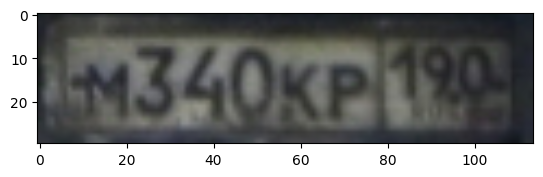

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

result = inference(filename)
print("text: ", result)

image = mpimg.imread(filename)
plt.imshow(image, interpolation='bilinear')
plt.show()

In [ ]:
result = inference("/content/0001.jpg")
print("text: ", result)